Notebook for running regression on tree models using higher rank signatures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import Tree_Process_utils as TP
from math import ceil
from tqdm import tqdm

np.random.seed(42)

Tree processes can be initialised from data in the following format. Calling print on the tree will generate every path along with its probability.

In [2]:
data = (0, [0.5,0.5], [-1,(1,[0.5,0.5], [2,0])])
T = TP.TreeProcess(data)
print(T)
print(T.ExpSig(3, Augment = True))

p = 0.5: 
 [0, -1] 

p = 0.25: 
 [0, 1, 2] 

p = 0.25: 
 [0, 1, 0] 


Tensor series of dimension = 2 and degree = 3. Values: 
0 : [1.] 
1 : [1.5 0. ] 
2 : [[1.25 0.  ]
 [0.5  0.75]] 
3 : [[[0.75 0.  ]
  [0.25 0.5 ]]

 [[0.5  0.25]
  [0.5  0.25]]] 



In [3]:
def genPath(path = 'X', epsilon = 0.01, noise = 1): 
    #generates a path from distribution X or Y depending on the inputted noise
    if path=='X':
        data = (0, [0.5,0.5], [(1,[0.5, 0.5], [noise+2, noise]),
                               (-1,[0.5, 0.5], [noise-2, noise])])
    if path=='Y':
        data = (0, [0.5,0.5], [(np.sqrt(1-epsilon**2) + noise * epsilon, [0.5, 0.5], [noise+2, noise]),
                               (-np.sqrt(1-epsilon**2) + noise * epsilon,[0.5, 0.5], [noise-2, noise])])
    return TP.TreeProcess(data)

def genPaths(epsilon, N):
    labels = np.random.binomial(1,0.5,N)
    noise = np.random.normal(0,1,N)
    paths = [genPath('X' if labels[i]==1 else 'Y', epsilon, noise[i]) for i in range(N)]
    return labels, paths

def genBatch(paths, N=2, rank=1):
    if rank == 1:
        sigs = [t.ExpSig(N, Augment = True) for t in paths]
    if rank == 2:
        sigs = [t.ExpSigr2(N, Augment = True)[1] for t in paths]
    return np.array([s.flatten() for s in sigs])

The truncated rank 1 expected signature has dimension 127, and the truncated rank 2 expected signature has dimension 76.

In [4]:
dim1 = genBatch([genPath(path = 'X')], rank=2, N=3).size
dim2 = genBatch([genPath(path = 'Y')], rank=1, N=6).size

print(dim1, dim2)

76 127


In [5]:
def Exper(epsilon, batchSizes):
    S1 = []
    S2 = []
    clf = linear_model.SGDClassifier(max_iter=5000, tol=1e-5)
    scaler = MinMaxScaler()
    
    N = batchSizes[-1]
    labels, data = genPaths(epsilon, ceil(2*N))
    f1 = genBatch(data, rank=1, N=6)
    f2 = genBatch(data, rank=2, N=3)
    
    f1 = scaler.fit_transform(f1)
    f2 = scaler.fit_transform(f2)
    
    f1_train, f1_test, f2_train, f2_test, labels_train, labels_test = train_test_split(f1, f2, labels, test_size=0.5)
    
    for Ba in tqdm(batchSizes):
        n = ceil(Ba)
        s1 = clf.fit(f1_train[:n], labels_train[:n]).score(f1_test, labels_test)
        s2 = clf.fit(f2_train[:n], labels_train[:n]).score(f2_test, labels_test)
        S1.append(s1)
        S2.append(s2)
        
    return S1, S2

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 391.49it/s]


Text(0,0.5,'Accuracy')

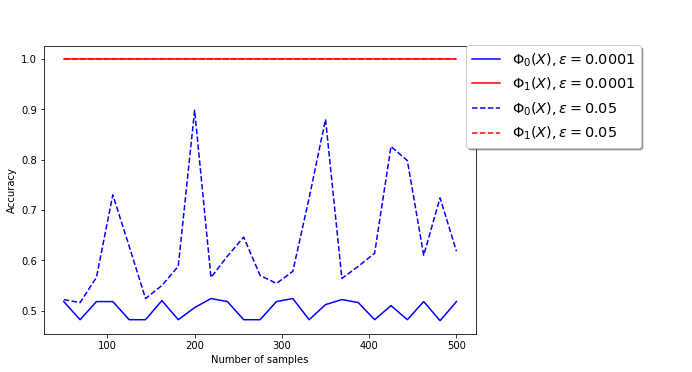

In [6]:
batchSizes = np.linspace(50, 500, num=25)
epsilon_small = 0.0001
epsilon_large = 0.05


A1,A2 = Exper(epsilon_small, batchSizes)
B1,B2 = Exper(epsilon_large, batchSizes)

fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 1, 1])
ax.plot(batchSizes, [x for x in A1], 'b', label=r'$\Phi_0(X), \varepsilon = {}$'.format(epsilon_small))
ax.plot(batchSizes, [x for x in A2], 'r', label=r'$\Phi_1(X), \varepsilon = {}$'.format(epsilon_small))
ax.plot(batchSizes, [x for x in B1], 'b--', label=r'$\Phi_0(X), \varepsilon = {}$'.format(epsilon_large))
ax.plot(batchSizes, [x for x in B2], 'r--', label=r'$\Phi_1(X), \varepsilon = {}$'.format(epsilon_large))

legend = fig1.legend(bbox_to_anchor=(1.5, 1.16), shadow=True, fontsize='x-large')

ax.set_xlabel('Number of samples')
ax.set_ylabel('Accuracy')

In [7]:
fig1.savefig('exp2.pdf',bbox_inches="tight")

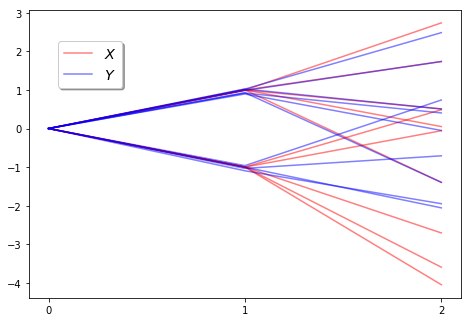

In [10]:
N = 10
noise = np.random.normal(0,1,N)
A = [genPath('X', 0.05, noise[i]).sample() for i in range(N)]
B = [genPath('Y', 0.05, noise[i]).sample() for i in range(N)]

fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 1, 1])
ax.plot(range(3), np.transpose(A), 'r', alpha=0.5)
ax.plot(range(3), np.transpose(B), 'b', alpha=0.5)

ax.plot(0,0, 'r', alpha=0.5, label=r'$X$')
ax.plot(0,0, 'b', alpha=0.5, label=r'$Y$')
ax.xaxis.set_ticks([0,1,2])

legend = fig1.legend(bbox_to_anchor=(0.3, 1), shadow=True, fontsize='x-large')

In [11]:
fig1.savefig('exp2samples.pdf',bbox_inches="tight")